# mCNV Analysis

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels as sms
import statsmodels.api as sm
import statsmodels.formula.api
import statsmodels.formula.api as smf
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'mcnv_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

In [3]:
dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_encode_dnase_overlap.tsv')
encode_dnase_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_encode_tf_chip_seq_overlap.tsv')
encode_chip_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_roadmap_overlap.tsv')
roadmap_overlap = pd.read_table(fn, index_col=0)

In [5]:
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_info.pickle')
gs_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'mcnvs.tsv')
mcnvs = pd.read_table(fn, index_col=0)

In [6]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
eqtl_tpm = pd.read_table(fn, index_col=0)
eqtl_tpm = eqtl_tpm[(gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrX') & 
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrY') &
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrM')]

## mCNV eQTLs

I want to test for an association between mCNVs and gene expression. I'm going to start
by using unrelated individuals. There are genetically unrelated people in families (for
instance the parents in a trio are unrelated) but for now I'll just take one person from
each family.

### mCNV samples

In [7]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'unrelateds.tsv')
mcnv_samples = pd.read_table(fn, index_col=0)

In [8]:
mcnv_samples_by_wgs = mcnv_samples.copy(deep=True)
mcnv_samples_by_wgs['rna_id'] = mcnv_samples_by_wgs.index
mcnv_samples_by_wgs.index = mcnv_samples_by_wgs.wgs_id
mcnv_samples_by_wgs = mcnv_samples_by_wgs.merge(subject_meta, left_on='subject_id', right_index=True)

### mCNV filtering

I'll filter the mCNVs based on the samples I'm using here.

In [9]:
mcnvs_f = mcnvs[mcnv_samples.wgs_id]
b = mcnvs_f.apply(lambda x: x.value_counts().max() < mcnvs_f.shape[1] - np.floor(mcnvs_f.shape[1] * 0.05), axis=1)
mcnvs_f = mcnvs_f[b]

In [10]:
t = gs_info.ix[mcnvs_f.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
mcnvs_bt = pbt.BedTool(s, from_string=True)
mcnvs_bt = mcnvs_bt.sort()

In [11]:
# Let's find out which mCNVs overlap the variant regions for the genes.
res = mcnvs_bt.intersect(variant_regions, sorted=True, wo=True)
df = res.to_dataframe()
df['gene'] = df.thickEnd.apply(lambda x: x.split('_')[0])
# I'll make a mapping from gene to mCNV.
gene_to_mcnv = pd.Series(df.name.values, index=df.gene)

In [12]:
eqtl_tpm_f = eqtl_tpm[mcnv_samples.wgs_id]
eqtl_tpm_f = cpb.general.transform_standard_normal(eqtl_tpm_f)

In [13]:
mcnvs_f.to_csv(os.path.join(private_outdir, 'filtered_mcnvs.tsv'), sep='\t')

### Regression

In [15]:
def mcnv_data(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    return data

def mcnv_regression(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    data = mcnv_data(gene)
    results = {}
    for cnv in cnvs:
        results[cnv] = statsmodels.formula.api.ols('exp ~ {} + sex'.format(cnv), data=data).fit()
    return results

In [16]:
se = gene_to_mcnv.ix[set(gene_to_mcnv.index) & set(eqtl_tpm_f.index)]
print('{:,} total tests'.format(se.shape[0]))
print('{:,} distinct genes'.format(len(set(se.index))))
print('{:,} distinct mCNVs'.format(len(set(se.values))))

6,126 total tests
1,330 distinct genes
370 distinct mCNVs


In [17]:
fn = os.path.join(outdir, 'results.pickle')
if not os.path.exists(fn):
    ind = list(set(gene_to_mcnv.index) & set(eqtl_tpm_f.index))
    gene_results = []
    for g in ind:
        gene_results.append(mcnv_regression(g))
    with open(fn , 'w') as f:
        cPickle.dump(gene_results, f)
else:
    gene_results = cPickle.load(open(fn))

In [18]:
fn = os.path.join(outdir, 'reg_results.tsv')
if not os.path.exists(fn):
    g = []
    c = []
    p = []
    b = []
    for i,d in enumerate(gene_results):
        for k in d.keys():
            g.append(ind[i])
            c.append(k)
            p.append(d[k].pvalues[k])
            b.append(d[k].params[k])
    reg_results = pd.DataFrame({'gene':g, 'cnv':c, 'pvalue':p, 'beta':b})
    r = sms.sandbox.stats.multicomp.multipletests(reg_results.pvalue, method='fdr_bh')
    reg_results['bh_pvalue'] = r[1]
    reg_results['bh_sig'] = r[0]
    reg_results = reg_results.merge(gs_info, left_on='cnv', right_index=True).drop(['name'], axis=1)
    reg_results = reg_results.merge(gene_info, left_on='gene', right_index=True, suffixes=['', '_gene'])
    reg_results['overlap_gene'] = (((reg_results.start > reg_results.start_gene) & 
                                    (reg_results.start < reg_results.end_gene)) | 
                                   ((reg_results.end > reg_results.start_gene) & 
                                    (reg_results.end < reg_results.end_gene)))
    a = reg_results.end - reg_results.start_gene
    b = reg_results.start - reg_results.end_gene
    t = pd.DataFrame([a,b]).T
    ta = t.abs()
    tv = t[ta.apply(lambda x: x == x.min(), axis=1)]
    tv = tv.fillna(0).sum(axis=1)
    reg_results['dist_to_gene'] = tv
    reg_results.ix[reg_results.overlap_gene, 'dist_to_gene'] = 0
    reg_results.to_csv(fn, sep='\t')
else:
    reg_results = pd.read_table(fn, index_col=0)
sig = reg_results[reg_results.bh_sig]
sig.sort_values(by='pvalue', inplace=True)

In [19]:
a = len(set(sig.gene))
b = len(set(sig.gene) - set(sig.ix[sig.overlap_gene, 'gene']))
print('{} mCNV eGenes, {} of which are intergenic.'.format(a, b))

88 mCNV eGenes, 62 of which are intergenic.


In [20]:
n = len(set(gene_variant.ix[gene_variant.variant_type == 'cnv', 'gene_id']) | 
        set(sig.gene))
print('{} genes have a significant CNV association considering both '
      'biallelic and mCNVs.'.format(n))

469 genes have a significant CNV association considering both biallelic and mCNVs.


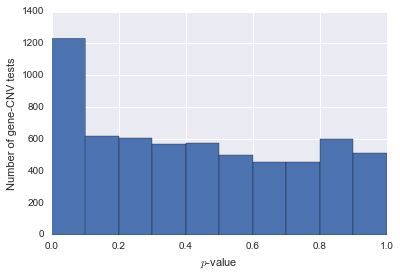

In [21]:
reg_results.pvalue.hist()
plt.ylabel('Number of gene-CNV tests')
plt.xlabel('$p$-value');

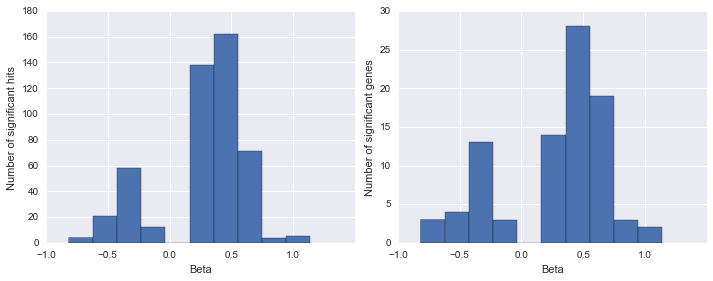

In [20]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig.beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
sig.drop_duplicates(subset=['gene']).beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

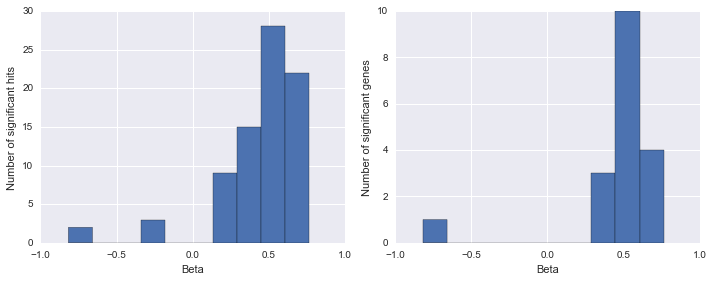

In [21]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig[sig.overlap_gene].beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
t = sig.drop_duplicates(subset=['gene'])
t[t.overlap_gene].beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

In [22]:
sig.shape

(475, 53)

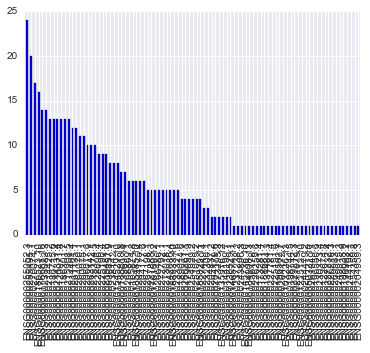

In [23]:
sig.gene.value_counts().plot(kind='bar')

In [24]:
len(set(sig.gene))

89

In [25]:
len(set(sig.ix[sig.overlap_gene, 'gene']))

24

In [26]:
sig.overlap_gene.value_counts()

False    396
True      79
Name: overlap_gene, dtype: int64

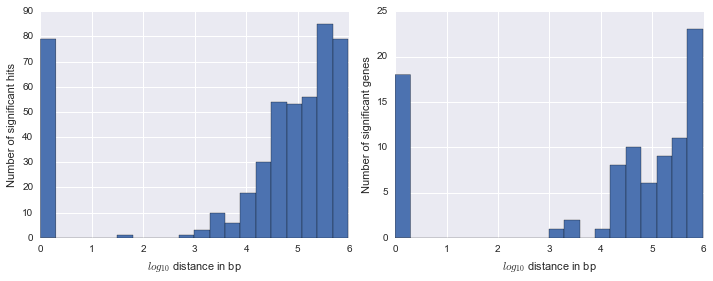

In [27]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
(np.log10(sig.dist_to_gene.abs() + 1)).hist(ax=ax, bins=20)
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('$log_{10}$ distance in bp');

ax = axs[1]
(np.log10(sig.drop_duplicates(subset=['gene']).dist_to_gene.abs() + 1)).hist(ax=axs[1], bins=20)
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('$log_{10}$ distance in bp');
plt.tight_layout()

In [28]:
def plot_results(gene):
    data = mcnv_data(gene)
    s = sig[sig.gene == gene]
    for c in s.cnv:
        sns.lmplot(x=c, y='exp', data=data, x_jitter=0.2)
        plt.ylabel(gene_info.ix[gene, 'gene_name'])

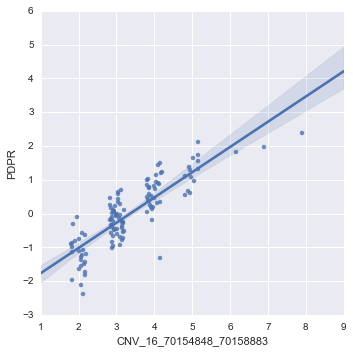

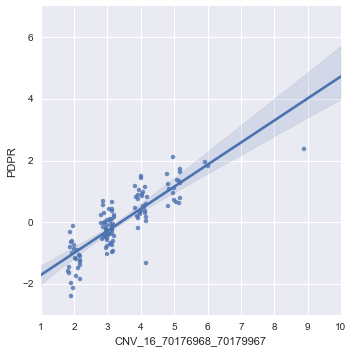

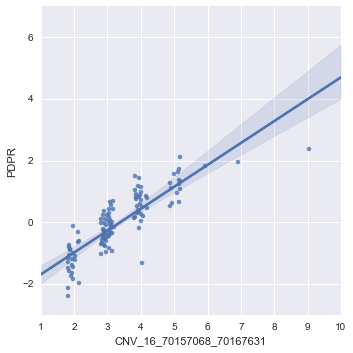

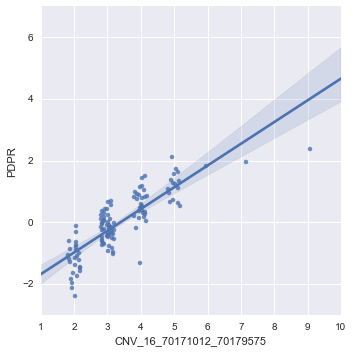

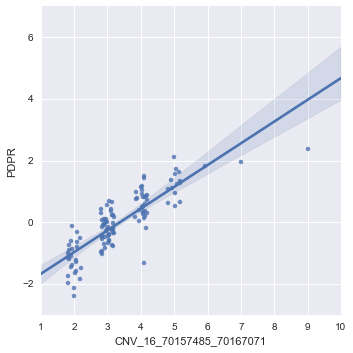

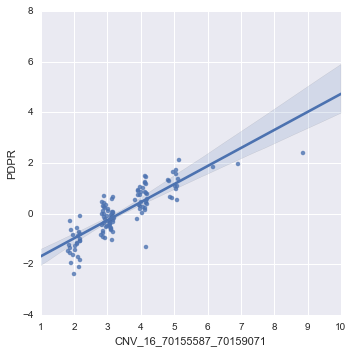

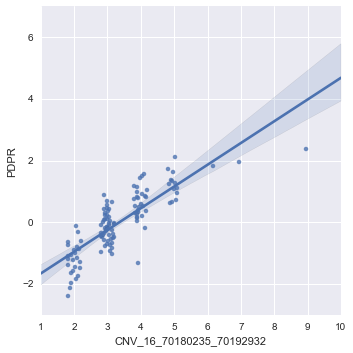

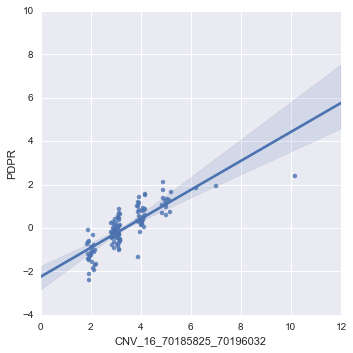

In [29]:
plot_results(sig.gene.drop_duplicates().values[0])

In [30]:
sig_cnvs = set(sig.cnv)
not_sig_cnvs = set(reg_results.cnv) - sig_cnvs
a = gs_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = gs_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

0.000648639720022


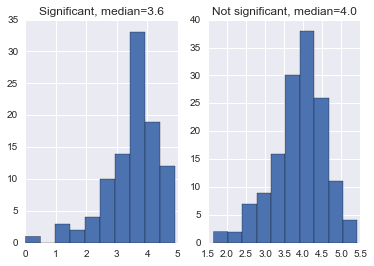

In [31]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

In [32]:
sig_cnvs = set(sig.cnv) - set(sig.ix[sig.overlap_gene, 'cnv'])
not_sig_cnvs = set(reg_results.cnv) - sig_cnvs
a = gs_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = gs_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

0.224307819241


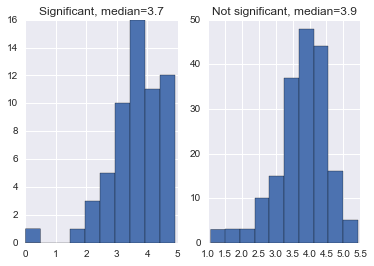

In [33]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

Significant CNVs are closer to the TSS than not significant CNVs, although
this is not true if you remove the significant CNVs that overlap the gene.

In [34]:
fn = os.path.join(outdir, 'go_results.tsv')
if not os.path.exists(fn):
    t = pd.Series(False, set(qvalues.index))
    t[set(sig.gene)] = True
    go_res = cpb.analysis.goseq_gene_enrichment(
        [x.split('.')[0] for x in t.index],
        t.values, 
        plot_fn=None, 
        length_correct=False)
    go_res.to_csv(fn, sep='\t')
else:
    go_res = pd.read_table(fn, index_col=0)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading hg19 length data...

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Fetching GO annotations...

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: AnnotationDbi

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: 

In [35]:
go_res.head()

,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_pvalue_bh,under_represented_pvalue_bh
category,,,,,,,,
GO:0005765,0.001959,0.999819,4,227,lysosomal membrane,CC,1,1
GO:0002408,0.002382,1.000000,1,1,myeloid dendritic cell chemotaxis,BP,1,1
GO:0034506,0.002382,1.000000,1,1,"chromosome, centromeric core domain",CC,1,1
GO:0005774,0.003476,0.999622,4,266,vacuolar membrane,CC,1,1
GO:0036324,0.004758,0.999995,1,2,vascular endothelial growth factor receptor-2 ...,BP,1,1


## Intergenic

I want to find genes where no CNV overlaps the gene at all.

In [36]:
subject_meta.ix[rna_meta[rna_meta.in_eqtl].subject_id].ethnicity_group.value_counts()

European                         142
Asian                             30
Multiple ethnicities reported     19
Hispanic                          14
African American                   4
Indian                             4
Middle Eastern                     2
Name: ethnicity_group, dtype: int64

In [37]:
sig.sort_values(by='overlap_gene', ascending=False).drop_duplicates(subset=['gene']).overlap_gene.value_counts()

False    65
True     24
Name: overlap_gene, dtype: int64

In [38]:
44282354 - 44367851

-85497

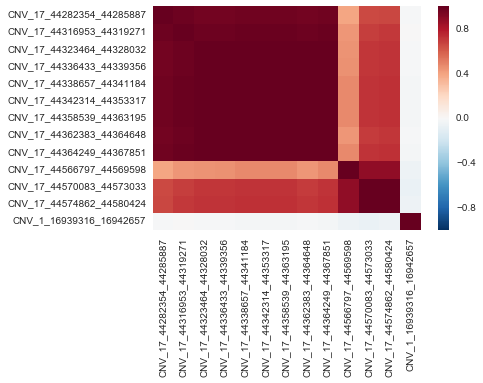

In [80]:
c = mcnvs_f.ix[sorted(sig.cnv.value_counts().head(13).index)].T.corr(method='spearman')
sns.heatmap(c)#, xticklabels=[], yticklabels=[]);

In [83]:
sig[sig.cnv == 'CNV_17_44316953_44319271'].gene_name

3296        KANSL1
689      LRRC37A4P
2338      LRRC37A2
2146    KANSL1-AS1
5174       LRRC37A
4792        DND1P1
1969         NSFP1
4135        ARL17B
1699       PLEKHM1
20      LRRC37A17P
Name: gene_name, dtype: object

In [81]:
c

,CNV_17_44282354_44285887,CNV_17_44316953_44319271,CNV_17_44323464_44328032,CNV_17_44336433_44339356,CNV_17_44338657_44341184,CNV_17_44342314_44353317,CNV_17_44358539_44363195,CNV_17_44362383_44364648,CNV_17_44364249_44367851,CNV_17_44566797_44569598,CNV_17_44570083_44573033,CNV_17_44574862_44580424,CNV_1_16939316_16942657
CNV_17_44282354_44285887,1.000000,0.980630,0.968434,0.967787,0.968762,0.968762,0.968762,0.966833,0.968762,0.392523,0.657097,0.667533,-0.012783
CNV_17_44316953_44319271,0.980630,1.000000,0.981890,0.981462,0.987345,0.987345,0.987345,0.980313,0.987345,0.444507,0.692726,0.703633,0.005101
CNV_17_44323464_44328032,0.968434,0.981890,1.000000,0.997451,0.994626,0.994626,0.994626,0.996475,0.994626,0.450508,0.711446,0.722787,-0.012796
CNV_17_44336433_44339356,0.967787,0.981462,0.997451,1.000000,0.994186,0.994186,0.994186,0.995658,0.994186,0.457453,0.714959,0.726295,-0.012691
CNV_17_44338657_44341184,0.968762,0.987345,0.994626,0.994186,1.000000,1.000000,1.000000,0.992952,1.000000,0.477026,0.719865,0.731206,-0.018180
CNV_17_44342314_44353317,0.968762,0.987345,0.994626,0.994186,1.000000,1.000000,1.000000,0.992952,1.000000,0.477026,0.719865,0.731206,-0.018180
CNV_17_44358539_44363195,0.968762,0.987345,0.994626,0.994186,1.000000,1.000000,1.000000,0.992952,1.000000,0.477026,0.719865,0.731206,-0.018180
CNV_17_44362383_44364648,0.966833,0.980313,0.996475,0.995658,0.992952,0.992952,0.992952,1.000000,0.992952,0.441323,0.702577,0.713691,-0.011634
CNV_17_44364249_44367851,0.968762,0.987345,0.994626,0.994186,1.000000,1.000000,1.000000,0.992952,1.000000,0.477026,0.719865,0.731206,-0.018180
CNV_17_44566797_44569598,0.392523,0.444507,0.450508,0.457453,0.477026,0.477026,0.477026,0.441323,0.477026,1.000000,0.889960,0.888392,-0.048953


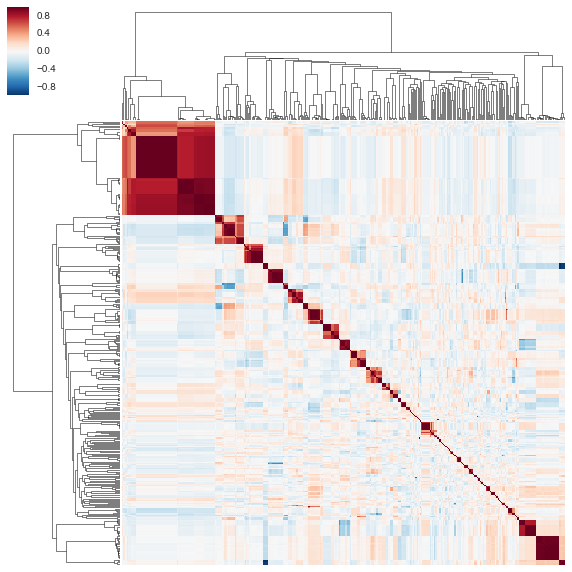

In [74]:
c = mcnvs_f.T.corr(method='spearman')
sns.clustermap(c, xticklabels=[], yticklabels=[]);

In [41]:
se = c['CNV_7_143951166_143953316']
se[se > 0.8]

CNV_7_143951166_143953316    1
Name: CNV_7_143951166_143953316, dtype: float64

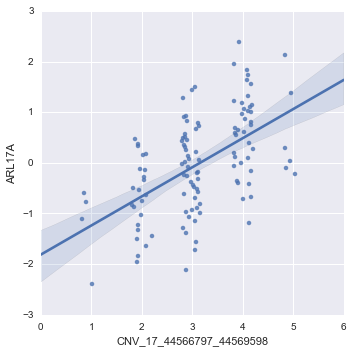

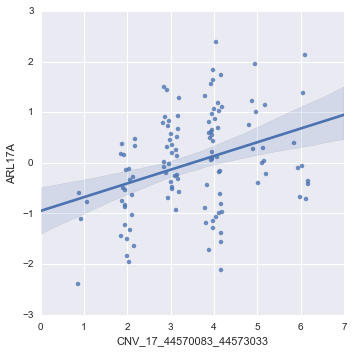

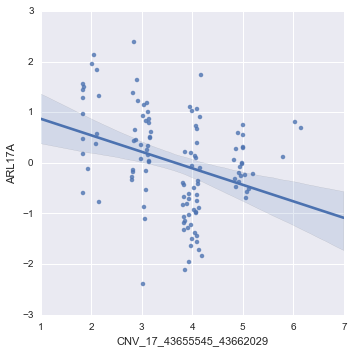

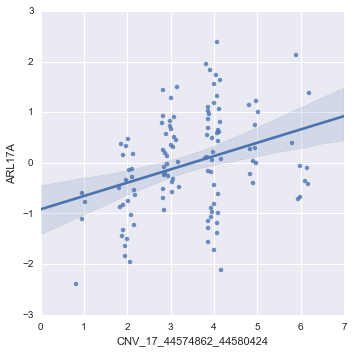

In [42]:
plot_results('ENSG00000185829.11')

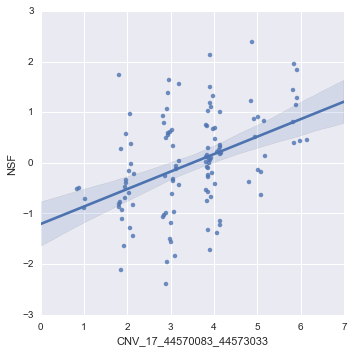

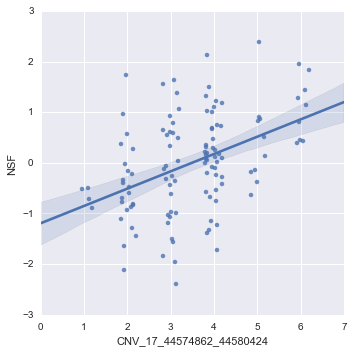

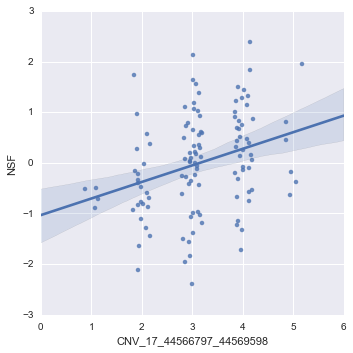

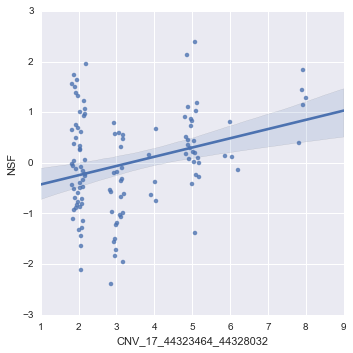

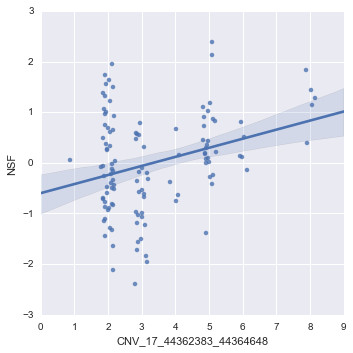

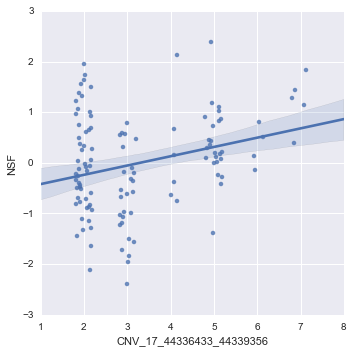

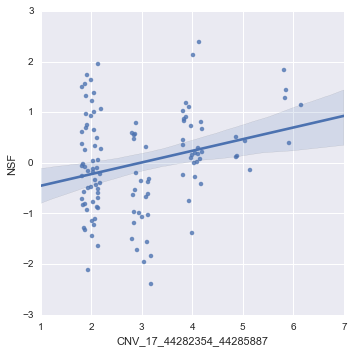

In [43]:
plot_results('ENSG00000073969.14')

In [44]:
gene_info.ix[sig[sig.cnv == 'CNV_17_44566797_44569598'].gene]

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level,ensembl_id
gene_id,,,,,,,,,,
ENSG00000238083.3,LRRC37A2,protein_coding,chr17,44588876,44633016,+,KNOWN,HAVANA,2,ENSG00000238083
ENSG00000185829.11,ARL17A,protein_coding,chr17,44594067,44657088,-,KNOWN,HAVANA,2,ENSG00000185829
ENSG00000131484.3,RP11-798G7.5,antisense,chr17,43580625,43612076,+,NOVEL,HAVANA,2,ENSG00000131484
ENSG00000176681.10,LRRC37A,protein_coding,chr17,44370098,44415160,+,KNOWN,HAVANA,2,ENSG00000176681
ENSG00000267198.1,RP11-798G7.6,lincRNA,chr17,43623169,43640596,+,NOVEL,HAVANA,2,ENSG00000267198
ENSG00000232300.1,FAM215B,sense_intronic,chr17,44636195,44640161,-,NOVEL,HAVANA,2,ENSG00000232300
ENSG00000214401.4,KANSL1-AS1,antisense,chr17,44270941,44274089,+,NOVEL,HAVANA,2,ENSG00000214401
ENSG00000120071.8,KANSL1,protein_coding,chr17,44107281,44302733,-,KNOWN,HAVANA,1,ENSG00000120071
ENSG00000228696.4,ARL17B,protein_coding,chr17,44352149,44439130,-,KNOWN,HAVANA,2,ENSG00000228696


In [45]:
mcnvs_f.ix[sig.cnv.value_counts().head(13).index]

,34c79720-7710-4f86-b1fc-ef6565ab8459,985362a3-e536-4368-8996-2bc2db0d8fd5,e80ac498-b700-437a-a09b-fb18737772cd,4d04f714-2d68-4663-8c69-ed16606670b0,6354fc10-d70a-4453-b414-0d023f8de3b5,00ac22e8-826e-49df-8216-04571b00ac21,3ff1ec68-6cb9-4f9f-b2c8-5f318be79163,0f518720-9d4b-4985-a620-edb44511dce9,977ddaa3-25a9-44e8-a129-de5ee8c6bfc8,f8433b1c-dcf4-4eb2-b170-b1a218a22cd2,...,4fb56c9d-a815-462e-ba66-bae060c53a65,881b1e4e-d02c-4dcf-a5ae-49ffb8ef3347,91bb182f-aeff-4340-aaf5-99b1d57ba5f9,62e55d9a-4bf7-4ab1-bfc1-32b711e68dd4,41b56a79-65a4-44d0-8f3e-86c7d6621fcb,9127d78b-54a1-4be2-a6b9-40097c8cbc5a,c2a8ad0d-aaa0-4c29-a9b2-6e6617995a7d,916c0056-cef2-488f-ae44-cb9b1398669e,c7a966f7-e22e-4807-afff-2bae9ca5fc72,4f63a2f0-b270-48f8-8603-38d0de2bec74
CNV_17_44574862_44580424,4,3,3,4,4,3,4,4,2,5,...,4,4,2,4,3,2,4,2,3,4
CNV_17_44566797_44569598,3,3,3,3,4,4,3,4,2,5,...,3,3,2,4,3,2,3,2,3,4
CNV_17_44570083_44573033,4,3,3,4,4,3,4,4,2,5,...,4,4,2,4,3,2,4,2,3,4
CNV_17_44316953_44319271,4,2,3,4,3,3,4,2,2,4,...,4,4,2,3,3,2,4,2,3,2
CNV_17_44362383_44364648,5,2,3,5,3,3,5,2,2,4,...,5,5,2,3,3,2,5,2,3,2
CNV_17_44338657_44341184,4,2,3,4,3,3,4,2,2,4,...,4,4,2,3,3,2,4,2,3,2
CNV_17_44358539_44363195,4,2,3,4,3,3,4,2,2,4,...,4,4,2,3,3,2,4,2,3,2
CNV_17_44342314_44353317,4,2,3,4,3,3,4,2,2,4,...,4,4,2,3,3,2,4,2,3,2
CNV_17_44364249_44367851,4,2,3,4,3,3,4,2,2,4,...,4,4,2,3,3,2,4,2,3,2
CNV_17_44336433_44339356,5,2,3,5,3,3,5,2,2,4,...,5,5,2,3,3,2,4,2,3,2


In [46]:
sig_intergenic_cnvs = set(sig.cnv) - set(sig.ix[sig.overlap_gene, 'cnv'])
not_sig_cnvs = set(reg_results.cnv) - set(sig.cnv)

In [25]:
data.head()

,CNV_7_143951166_143953316,exp,sex,gene
34c79720-7710-4f86-b1fc-ef6565ab8459,2,-1.434200,False,ARHGEF34P
985362a3-e536-4368-8996-2bc2db0d8fd5,5,0.537519,False,ARHGEF34P
4d04f714-2d68-4663-8c69-ed16606670b0,3,-0.494133,True,ARHGEF34P
6354fc10-d70a-4453-b414-0d023f8de3b5,2,-1.062786,True,ARHGEF34P
00ac22e8-826e-49df-8216-04571b00ac21,2,-0.937532,False,ARHGEF34P


In [44]:
gs = ['OR2AO1P', 'ARHGEF35', 'CTAGE4', 'OR2A42', 'OR2A20P', 'CTAGE8', 'OR2A9P', 'OR2A1']
for g in gs:
    print(g, g in set(gene_info.ix[eqtl_tpm_f.index, 'gene_name']),
          g in set(gene_info.gene_name))

('OR2AO1P', False, True)
('ARHGEF35', True, True)
('CTAGE4', True, True)
('OR2A42', False, True)
('OR2A20P', True, True)
('CTAGE8', True, True)
('OR2A9P', True, True)
('OR2A1', False, True)


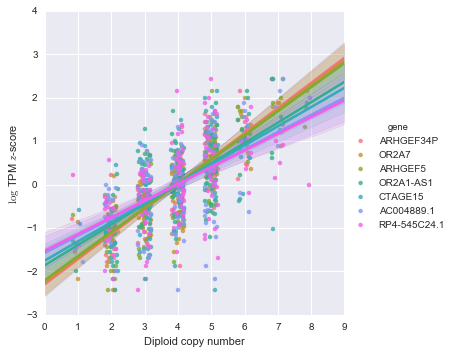

In [27]:
# s = set(sig.ix[sig.overlap_gene, 'gene'])
# t = sig[sig.gene.apply(lambda x: x not in s)]
# tt = t[t.cnv == 'CNV_7_143951166_143953316']
tt = sig[sig.cnv == 'CNV_7_143951166_143953316']

data = []
for gene in tt.gene:
    d = mcnv_data(gene)
    d['gene'] = gene_info.ix[gene, 'gene_name']
    data.append(d)
data = pd.concat(data)

data.to_csv(os.path.join(outdir, 'CNV_7_143951166_143953316_data.tsv'), sep='\t')

sns.lmplot(x='CNV_7_143951166_143953316', y='exp', data=data, hue='gene', x_jitter=0.2)
plt.ylabel('$\log$ TPM $z$-score')
plt.xlabel('Diploid copy number')
plt.savefig(os.path.join(outdir, 'CNV_7_143951166_143953316_example.pdf'))

In [29]:
bt = pbt.BedTool('/projects/CARDIPS/pipeline/ATACseq/merged_peaks/family_study_ipsc/family_study_ipsc_merged_peaks.bed')
bt2 = pbt.BedTool('chr7\t143951166\t143953316\n', from_string=True)

In [35]:
res = bt.intersect(bt2, wo=True)

In [37]:
143953316 - 143951166

2150

In [38]:
143951914 - 143951824

90

In [36]:
res.head()

chr7	143951824	143951914	chr7:143951824-143951914	chr7	143951166	143953316	90
 

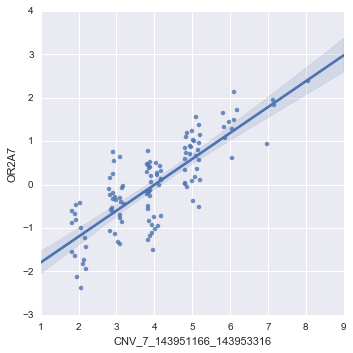

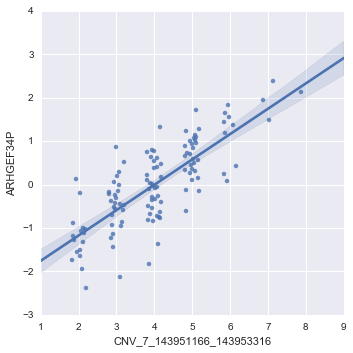

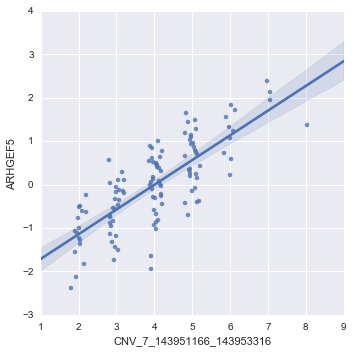

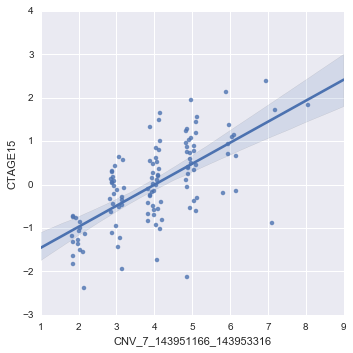

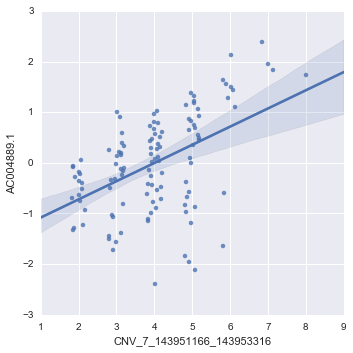

In [48]:
for g in tt.gene:
    plot_results(g)

In [49]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind

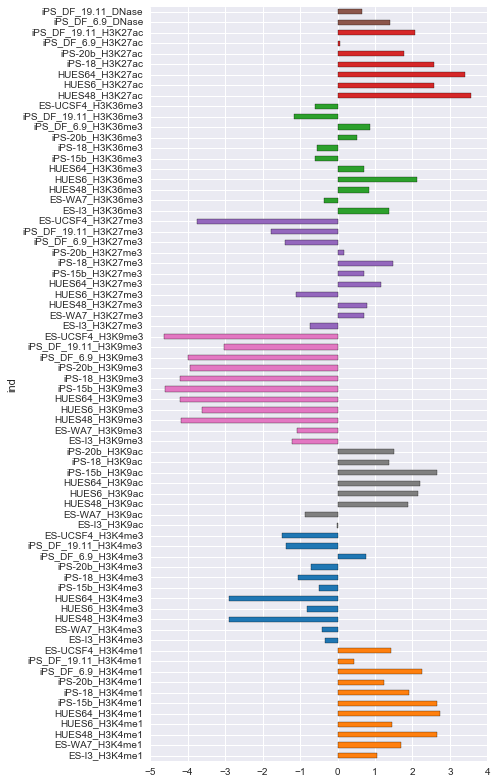

In [71]:
plt.figure(figsize=(7, 11))
(np.log2(roadmap_res.odds)).plot(kind='barh', color=roadmap_res.color)
plt.xlabel('')
plt.tight_layout()

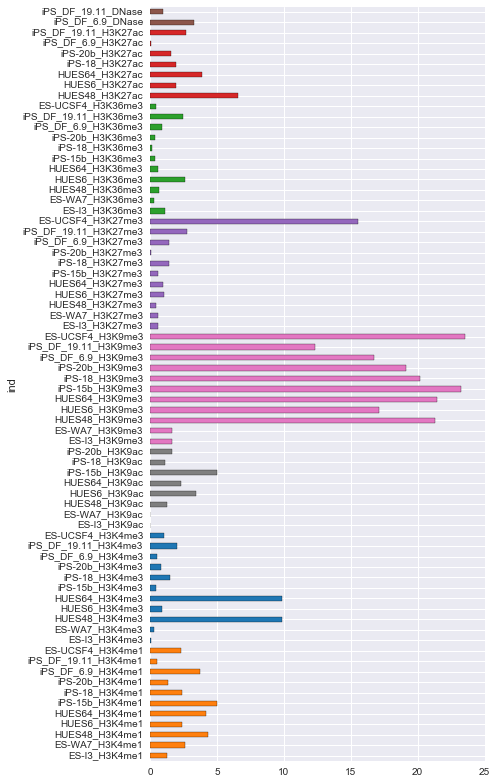

In [51]:
plt.figure(figsize=(7, 11))
(-np.log10(roadmap_res.pvalue)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()

In [52]:
odds = []
pvalues = []
for c in encode_dnase_overlap.columns:
    vc = (encode_dnase_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_dnase_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_dnase_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_dnase_overlap.columns)

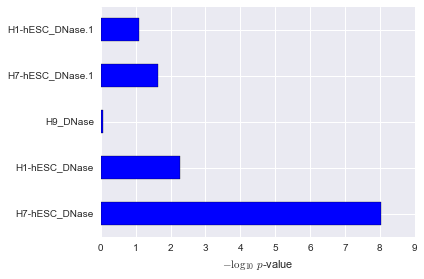

In [73]:
(-np.log10(encode_dnase_res.pvalue)).plot(kind='barh')
plt.xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout()

In [54]:
odds = []
pvalues = []
for c in encode_chip_overlap.columns:
    vc = (encode_chip_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_chip_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        not_sig_overlap = 0
    else:
        not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_chip_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_chip_overlap.columns)
encode_chip_res.sort_values(by='pvalue', inplace=True, ascending=False)

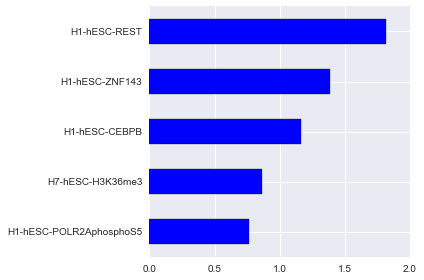

In [55]:
(-np.log10(encode_chip_res.pvalue.tail())).plot(kind='barh')
plt.tight_layout()

In [56]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

In [57]:
def get_hic_interactions(cnv, gene):
    # CNV location
    chrom,start,end = gs_info.ix[cnv, ['chrom', 'start', 'end']].values
    r = '{}:{}-{}'.format(chrom, start, end)
    fn = ('/projects/CARDIPS/pipeline/Hi-C/7_indv_HiC/contact_matrices/'
          'merged/normalized/iPSC/iPSC.5Kb.nor.{}.bed.gz'.format(chrom))
    t = tabix.open(fn)
    # Get lines for CNV.
    lines = []
    res = t.querys(r)
    while True:
        try:
            lines.append(res.next())
        except StopIteration:
            break
    # Get promoter regions.
    ps = [cpb.general.parse_region(x) for x in gene_to_promoters[gene]]
    # Get indices of columns for promoter regions.
    cols = []
    for x in ps:
        cols += range(int(x[1]) / 5000, int(x[2]) / 5000 + 1)
    cols = sorted(list(set(cols)))
    vals = []
    # Get values for promoter regions.
    for line in lines:
        vals.append([float(line[x + 3]) for x in cols])
    df = pd.DataFrame(vals)
    df.columns = np.array(cols) * 5000
    df.index = np.arange((start / 5000) * 5000, (end / 5000 + 1) * 5000, 5000)
    # Reflect over promoter regions and get interactions on other side.
    cnv_middle = int(start + (end - start) / 2.)
    promoter_middle = int(df.columns[0] + (df.columns[-1] - df.columns[0]) / 2.)
    null_start = int(2 * promoter_middle - cnv_middle - (end - start) / 2.)
    null_end = int(2 * promoter_middle - cnv_middle + (end - start) / 2.)
    if null_start < 0 or null_end < 0:
        return None, None
    else:
        # Get lines for CNV.
        r = '{}:{}-{}'.format(chrom, null_start, null_end)
        lines = []
        res = t.querys(r)
        while True:
            try:
                lines.append(res.next())
            except StopIteration:
                break
        vals = []
        # Get values for promoter regions.
        for line in lines:
            vals.append([float(line[x + 3]) for x in cols])
        null_df = pd.DataFrame(vals)
        null_df.columns = np.array(cols) * 5000
        null_df.index = np.arange((null_start / 5000) * 5000, (null_end / 5000 + 1) * 5000, 5000)
        return df, null_df

In [58]:
t = sig[sig.cnv.apply(lambda x: x in sig_intergenic_cnvs)]

In [59]:
real = []
null = []
dist = []
ind = []
for i in t.index:
    df, null_df = get_hic_interactions(t.ix[i, 'cnv'], t.ix[i, 'gene'])
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
        ind.append(i)
real = pd.Series(real)
null = pd.Series(null)

In [60]:
hic = pd.DataFrame({'real':real.values, 'null':null.values, 'dist':dist}, index=ind)

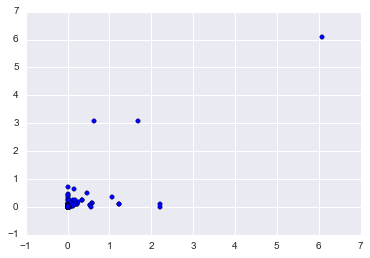

In [61]:
plt.scatter(hic.null * 10000, hic.real * 10000)

In [62]:
hic[hic.real * 10000 > 3]

,dist,null,real
2335,23333.333333,0.000169,0.000309
2337,28333.333333,0.000064,0.000309
1951,2500.000000,0.000609,0.000609


In [63]:
plot_results(t.ix[5764, 'gene'])

KeyError: 5764

In [ ]:
tdf = hic[hic.null == 0]

In [ ]:
tdf.sort_values(by='real', ascending=False, inplace=True)

In [ ]:
tdf.head()

In [ ]:
plot_results(t.ix[4537, 'gene'])